In [1]:
import numpy as np 
import pandas as pd 
import os
import tensorflow as tf
from tensorflow import keras
# from keras.preprocessing.image import load_img, array_to_img, img_to_array
from tensorflow.keras.utils import load_img, array_to_img, img_to_array
from keras.models import Model
from keras.layers import Conv2D, LeakyReLU, BatchNormalization, MaxPool2D,Conv2DTranspose, concatenate,Input
from keras import backend as K
import matplotlib.pyplot as plt

In [2]:
imgs_dir = '../../data/face-segmentation/img'
masks_dir = '../../data/face-segmentation/masks'

In [3]:
imgs_arr = np.zeros((len(os.listdir(imgs_dir)), 256, 256, 3), dtype = np.float32)
masks_arr = np.zeros((len(os.listdir(masks_dir)), 256, 256, 1), dtype = np.float32)



for index in range(len(os.listdir(imgs_dir))):
    img = load_img(os.path.join(imgs_dir, os.listdir(imgs_dir)[index]), target_size = (256, 256, 3))
    imgs_arr[index] = img_to_array(img)
    


for index in range(len(os.listdir(masks_dir))):
    img = load_img(os.path.join(masks_dir, os.listdir(masks_dir)[index]), target_size = (256, 256, 1), color_mode="grayscale" )
    masks_arr[index] = img_to_array(img)


imgs_arr /= 255.
masks_arr /= 255.



In [4]:
print(len(imgs_arr))
print(len(masks_arr))

20
20


In [5]:
from imgaug import augmenters as iaa
 
seq = iaa.Sequential([
    iaa.Crop (px = (0, 16)),
    iaa.Fliplr (0.5),
    iaa.GaussianBlur (sigma = (0, 1.2)),
#     iaa.Sharpen (alpha=1, lightness=1.1),
#     iaa.Emboss (alpha=1, strength=0.5),
#     iaa.EdgeDetect (alpha=0.1),
#     iaa.AdditiveGaussianNoise (scale=0.03 * 255),
#     iaa.Salt (p=0.01),
    iaa.PerspectiveTransform (scale=0.06)
])

for i in range(6):
    images_aug = seq.augment_images(imgs_arr)
    masks_aug = seq.augment_images(masks_arr)

    imgs_arr = np.concatenate((imgs_arr, images_aug))  
    masks_arr = np.concatenate((masks_arr, masks_aug))

x_train = imgs_arr[10:]
y_train = masks_arr[10:]

x_test = imgs_arr[0:10]
y_test = masks_arr[0:10]    

In [6]:
print(len(imgs_arr))
print(len(masks_arr))
print(len(x_train))
print(len(x_test))

1280
1280
1270
10


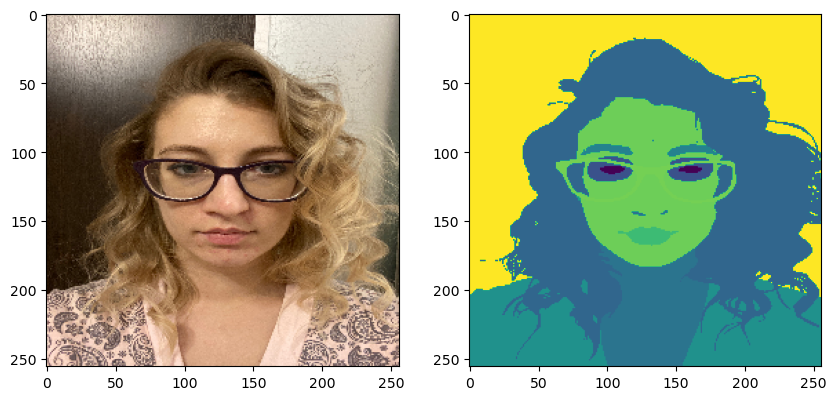

In [7]:
f = plt.figure(figsize=(10,10))
f.add_subplot(1,2, 1)
plt.imshow(imgs_arr[0])
f.add_subplot(1,2, 2)
plt.imshow(masks_arr[0])
plt.show(block=True)

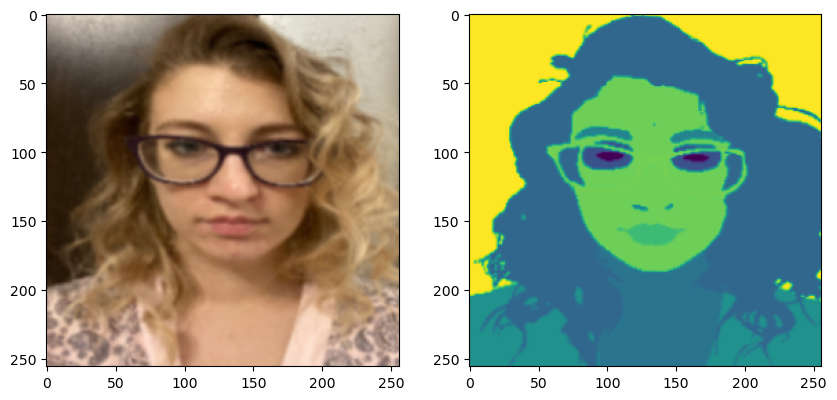

In [8]:
f = plt.figure(figsize=(10,10))
f.add_subplot(1,2, 1)
plt.imshow(imgs_arr[20])
f.add_subplot(1,2, 2)
plt.imshow(masks_arr[20])
plt.show(block=True)

In [9]:
def conv_block(inputs,n_filters,max_pool=True):
    x = Conv2D(n_filters,3,padding='same',kernel_initializer='he_normal',use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    x = Conv2D(n_filters,3,padding='same',kernel_initializer='he_normal',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    skip = x
    if max_pool:
        next_layer = MaxPool2D()(x)
    else:
        next_layer = x
    return next_layer, skip

# upsampling block 
def up_block(reg_inputs,skip_inputs,n_filters):
    x = Conv2DTranspose(n_filters,3,2,padding='same')(reg_inputs)
    x = concatenate([x,skip_inputs],axis=3)
    x = conv_block(x,n_filters,max_pool=False)[0]
    return x

In [10]:
def unet(input_size=(256,256,3),number_of_classes=1):
    inputs = Input(shape=input_size)
    cb1 = conv_block(inputs,32)
    cb2 = conv_block(cb1[0],64)
    cb3 = conv_block(cb2[0],128)
    cb4 = conv_block(cb3[0],256)
    cb5 = conv_block(cb4[0],512,max_pool=False)
    
    up1 = up_block(cb5[0],cb4[1],256)
    up2 = up_block(up1,cb3[1],128)
    up3 = up_block(up2,cb2[1],64)
    up4 = up_block(up3,cb1[1],32)
    
    conv1 = Conv2D(32,3,padding='same',kernel_initializer='he_normal',use_bias=False)(up4)
    bn = BatchNormalization()(conv1)
    lrl = LeakyReLU(0.2)(bn)
    outputs = Conv2D(number_of_classes,1,padding='same',activation='sigmoid')(lrl)
    
    unet = Model(inputs=inputs,outputs=outputs)
    return unet

In [11]:
# Jaccard coeficient or IoU
def jaccard_coef(y_true,y_pred,smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f*y_pred_f)
    return (intersection+smooth)/(K.sum(y_true_f)+K.sum(y_pred_f)-intersection+smooth)
# Jaccard loss
def jaccard_loss(y_true,y_pred,smooth=1):
    # We are multiplying IoU with -1 because we are trying to maximize the IoU so it will get bigger every iteration
    return -jaccard_coef(y_true,y_pred,smooth)

In [12]:
model = unet()

# model.summary()

In [13]:
model.compile(optimizer=keras.optimizers.Adam(1e-3),loss=[jaccard_loss],metrics=[jaccard_coef])

In [14]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3)

In [16]:
history = model.fit(x_train,y_train,batch_size=5,epochs=50,validation_split=0.2, verbose=1, callbacks=[early_stopping])

Epoch 1/50
204/204 [==============================] - 25s 116ms/step - loss: -0.6624 - jaccard_coef: 0.6625 - val_loss: -0.6447 - val_jaccard_coef: 0.6439
Epoch 2/50
204/204 [==============================] - 23s 111ms/step - loss: -0.6727 - jaccard_coef: 0.6731 - val_loss: -0.6612 - val_jaccard_coef: 0.6606
Epoch 3/50
204/204 [==============================] - 23s 111ms/step - loss: -0.6758 - jaccard_coef: 0.6753 - val_loss: -0.6647 - val_jaccard_coef: 0.6641
Epoch 4/50
204/204 [==============================] - 23s 114ms/step - loss: -0.6766 - jaccard_coef: 0.6760 - val_loss: -0.6652 - val_jaccard_coef: 0.6646
Epoch 5/50
204/204 [==============================] - 28s 135ms/step - loss: -0.6772 - jaccard_coef: 0.6774 - val_loss: -0.6656 - val_jaccard_coef: 0.6650
Epoch 6/50
204/204 [==============================] - 27s 134ms/step - loss: -0.6775 - jaccard_coef: 0.6780 - val_loss: -0.6658 - val_jaccard_coef: 0.6652
Epoch 7/50
204/204 [==============================] - 27s 132ms/step -

In [ ]:
model.save('first_model.h5')

In [ ]:
predictions = model.predict(x_test)

In [ ]:
def create_mask(predictions,input_shape=(256,256,1)):
    mask = np.zeros(input_shape)
    mask[predictions>0.5] = 1
    return mask

In [ ]:
def plot_results_for_one_sample(sample_index):
    mask = create_mask(predictions[sample_index])
    f = plt.figure(figsize=(20,20))
    f.add_subplot(1,4,1)
    plt.title('Input image')
    plt.imshow(x_test[sample_index])
    f.add_subplot(1,4,2)
    plt.title('Real mask')
    plt.imshow(y_test[sample_index])
    f.add_subplot(1,4,3)
    plt.title('Predicted mask')
    plt.imshow(mask)
    f.add_subplot(1,4,4)
    plt.title("Mask + image")
    plt.imshow(x_test[sample_index]*mask)

In [ ]:
plot_results_for_one_sample(0)